In [57]:
# Standard Math / Data libraries
import numpy as np
import pandas as pd

# Data Scrape Package
import pandas_datareader.data as web

# Plotting package
import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

# Keras Network @ https://www.tensorflow.org/guide/keras/gru
import tensorflow as tf # version tensorflow==2.4.0
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras import layers

import yfinance as yf
yf.pdr_override()

In [58]:
# Daily Data on Gold.
tick = 'GOOG'
google = web.get_data_yahoo(tick,'2015-11-4')

[*********************100%%**********************]  1 of 1 completed


In [59]:
google.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-11-04,36.099998,36.654999,36.095001,36.405499,36.405499,34134000
2015-11-05,36.473499,36.973999,36.473499,36.562500,36.562500,37232000
2015-11-06,36.575001,36.770500,36.350498,36.688000,36.688000,30232000
2015-11-09,36.509998,36.735500,35.971500,36.244499,36.244499,41396000
2015-11-10,36.220001,36.529499,35.924999,36.416000,36.416000,32160000


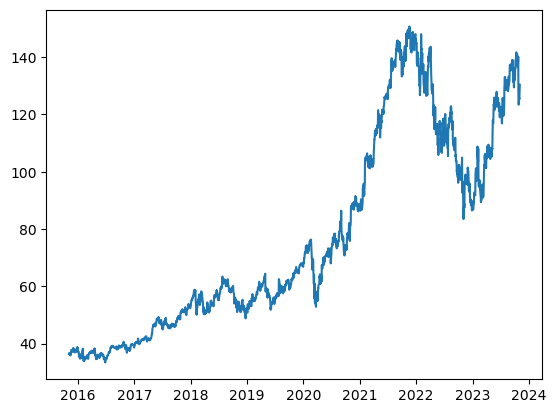

In [60]:
plt.plot(google['Adj Close'])


In [61]:
returns = google['Adj Close'].pct_change() # Used for univariate example.

column_names = google.columns
x = google.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [62]:
pct_c_google = df

In [63]:
pct_c_google.columns = column_names

In [64]:
pct_c_google.head()


,Open,High,Low,Close,Adj Close,Volume
0,0.022854,0.025657,0.025203,0.025512,0.025512,0.226601
1,0.026006,0.028350,0.028445,0.026851,0.026851,0.252412
2,0.026863,0.026632,0.027391,0.027921,0.027921,0.194091
3,0.026314,0.026337,0.024145,0.024140,0.024140,0.287104
4,0.023867,0.024598,0.023746,0.025602,0.025602,0.210154


# Predict future prices in GOOG (Multivariate Forecasting) using GRU

In [65]:
returns


Date
2015-11-04         NaN
2015-11-05    0.004313
2015-11-06    0.003432
2015-11-09   -0.012088
2015-11-10    0.004732
                ...   
2023-10-30    0.019044
2023-10-31   -0.003579
2023-11-01    0.018116
2023-11-02    0.007917
2023-11-03    0.013921
Name: Adj Close, Length: 2014, dtype: float64

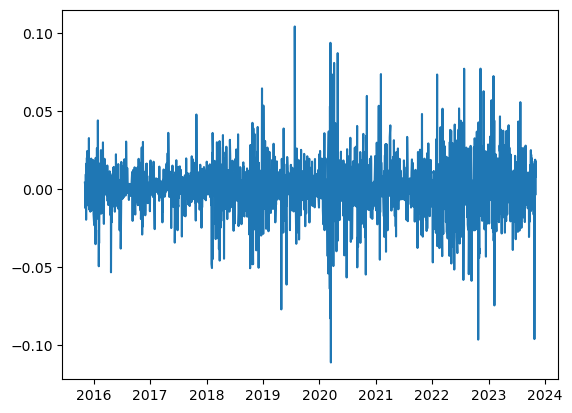

In [66]:
plt.plot(returns)


<Axes: >

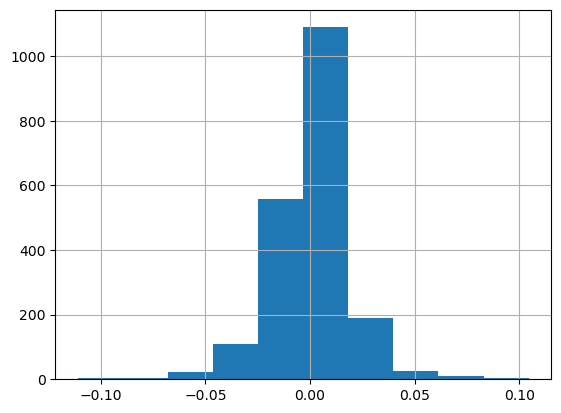

In [67]:
returns.hist()

In [68]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(pct_c_google.shape[0] - samples):
    X.append(pct_c_google.iloc[i:i+samples, 0:5].values) # Independent Samples
    Y.append(pct_c_google.iloc[i+samples, 5:].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  10 :  [array([[0.02285367, 0.02565723, 0.0252025 , 0.02551238, 0.02551238],
       [0.02600634, 0.02834956, 0.02844489, 0.02685089, 0.02685089],
       [0.02686311, 0.02663205, 0.0273912 , 0.02792083, 0.02792083],
       [0.02631443, 0.02633665, 0.02414454, 0.02413979, 0.02413979],
       [0.0238666 , 0.02459803, 0.02374619, 0.02560191, 0.02560191],
       [0.02726827, 0.02899099, 0.02877043, 0.02861992, 0.02861992],
       [0.02665207, 0.02764061, 0.02809153, 0.02684237, 0.02684237],
       [0.02587974, 0.02483434, 0.02298805, 0.0207765 , 0.0207765 ],
       [0.02015259, 0.02413383, 0.02067514, 0.02587474, 0.02587474],
       [0.02593039, 0.02512765, 0.02568519, 0.02431456, 0.02431456]])]
Testing Data: Length is  1 :  [array([0.22286838])]


In [69]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (2004, 10, 5) Dimensions of Y (2004, 1)


In [70]:
# # Get the training and testing set
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]
print('Training Length',trainX.shape, trainY.shape,'Testing Length:',testX.shape, testY.shape)

Training Length (1804, 10, 5) (1804, 1) Testing Length: (200, 10, 5) (200, 1)


In [76]:
# Let's build the GRU
model = keras.Sequential()

# Add a GRU layer with 15 units.
model.add(layers.GRU(15,
                     activation = "tanh",
                     recurrent_activation = "sigmoid",
                     input_shape=(X.shape[1], X.shape[2])))

# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 15)                990       
                                                                 
 dropout_4 (Dropout)         (None, 15)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 16        
                                                                 
Total params: 1006 (3.93 KB)
Trainable params: 1006 (3.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
# Fitting the data
history = model.fit(trainX,
                    trainY,
                    shuffle = False, # Since this is time series data
                    epochs=500,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/500
12/12 [==============================] - 1s 19ms/step - loss: 0.0829 - val_loss: 0.4607
Epoch 2/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0568 - val_loss: 0.2500
Epoch 3/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0447 - val_loss: 0.1381
Epoch 4/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0444 - val_loss: 0.0894
Epoch 5/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0428 - val_loss: 0.0648
Epoch 6/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0383 - val_loss: 0.0507
Epoch 7/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0336 - val_loss: 0.0422
Epoch 8/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0305 - val_loss: 0.0350
Epoch 9/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0266 - val_loss: 0.0270
Epoch 10/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0238 - val_loss: 0.0206
Epoch 11

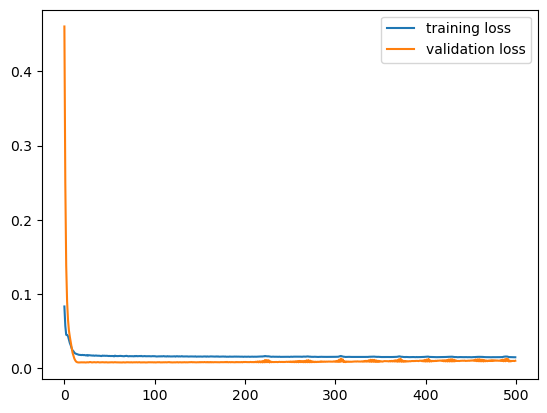

In [78]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

7/7 [==============================] - 0s 1ms/step


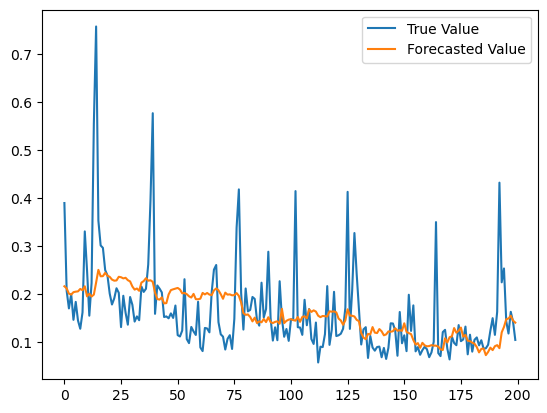

In [79]:
# This is a one step forecast (based on how we constructed our model)
y_pred = model.predict(testX)
plt.plot(testY, label = 'True Value')
plt.plot(y_pred, label = 'Forecasted Value')
plt.legend()